## Grid

In [13]:
import os.path as op
from pyproj import CRS
from shapely import Polygon
import pandas as pd


city_name = "Cantabria"
bathymetry_path = op.join("inputs", "bati_cantabria_100m.tif")

polygon_path = op.join("inputs", "Poly_cantabria.csv")
polygon_coords = pd.read_csv(polygon_path, sep=",")
polygon_domain = Polygon(polygon_coords)
polygon_domain_crs = CRS.from_user_input("epsg:4326")

### Parámetros de la malla

In [2]:
from datetime import datetime


tini = datetime(2020, 7, 11, 0, 0)
tend = datetime(2020, 7, 11, 17, 0)

mas = 0.5  # margen para recortar el raster (coeficiente SU)

H_dis = 0  # Nivel 0 (metros)
Rango_marea = 2  # (metros)
h_bnd = H_dis - 2 * Rango_marea

# Malla General
Tmin = 250  # Tamaño de celda mínimo (costas y islas) (metros)
Tfuera = 2500  # Tamaño de celda míaximo (contorno de la malla) (metros)
exp_rate = 0.01  # Velocidad de expansión de los triángulos entre Tmin y Tfuera (SU)
C_deb = 1  # Multiplicador de la fila de marea para el detalle a lo largo de la línea de contorno de la forma [Hdis-Rango_marea*C_deb , Hdis+Rango_marea*C_deb] (SU)

Tamano_min_islas = (
    200  # Tamano_min_islas (m^2) attencion function del tamaño minimo de celdas
)

min_dist_circum = 4  # distencia minima estre dos circumcenters para que la celda no sea borada (metros)

### Definir la forma global de la malla deseada, ruta de los archivos raster a utilizar (el último en la lista tiene mayor prioridad)

<Axes: title={'center': 'Raster'}, xlabel='Longitude', ylabel='Latitude'>

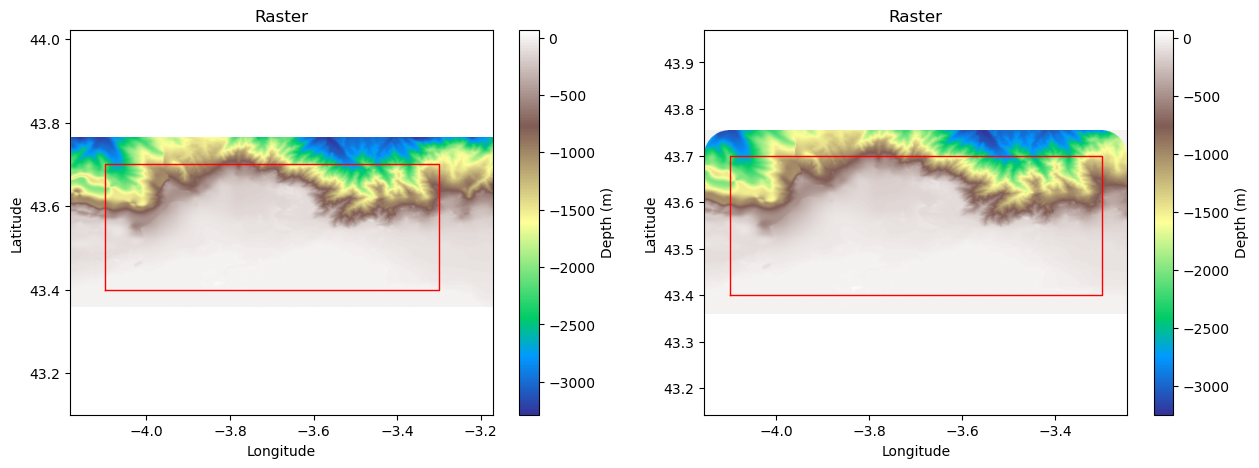

In [3]:
import matplotlib.pyplot as plt
from bluemath_tk.topo_bathy.mesh_utils import plot_bati, clip_bati


rasters_path_I = [bathymetry_path]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])

plot_bati(rasters_path_I, polygon_domain, axs[0])

output_clip_path = op.join("outputs", f"{city_name}_0_Batimetria_Clip.tif")
x_polygon, y_polygon = polygon_domain.exterior.xy
UTM_zone = int((x_polygon[0] + 180) / 6) + 1

clip_bati(rasters_path_I, output_clip_path, polygon_domain, mas, UTM_zone)
rasters_path = [output_clip_path]
plot_bati(rasters_path, polygon_domain, axs[1])

### Intersección de la forma de malla global con el nivel del mar para la línea de contorno

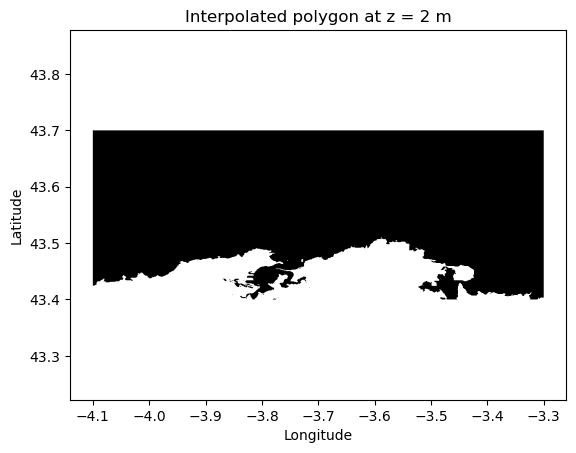

In [4]:
import ocsmesh
import geopandas as gpd


rasters = [ocsmesh.Raster(p) for p in rasters_path]

domain_p = ocsmesh.Geom(rasters, zmax=H_dis + Rango_marea).get_multipolygon()
base_shape = domain_p.intersection(polygon_domain)

gpd.GeoSeries(base_shape).plot(color="k")
plt.axis("equal")
plt.title(f"Interpolated polygon at z = {H_dis + Rango_marea} m")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Simplificación del polígono

<Axes: title={'center': 'Polygon Domain'}, xlabel='Longitude', ylabel='Latitude'>

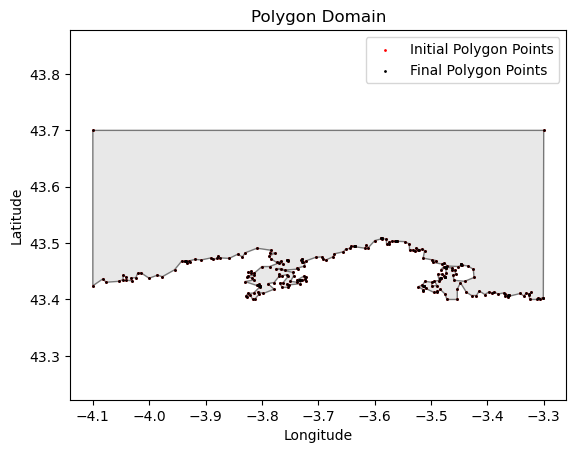

In [5]:
from bluemath_tk.topo_bathy.mesh_utils import simply_poly, remove_islands, plot_poly


final_shape = simply_poly(base_shape, Tmin * 0.8, UTM_zone)
largest_polygon = max(final_shape.geoms, key=lambda poly: poly.area)
final_polygon_UN = remove_islands(largest_polygon, Tamano_min_islas, UTM_zone)
plot_poly(largest_polygon, final_polygon_UN)

<Axes: title={'center': 'Mesh Design Criteria'}, xlabel='X UTM', ylabel='Y UTM'>

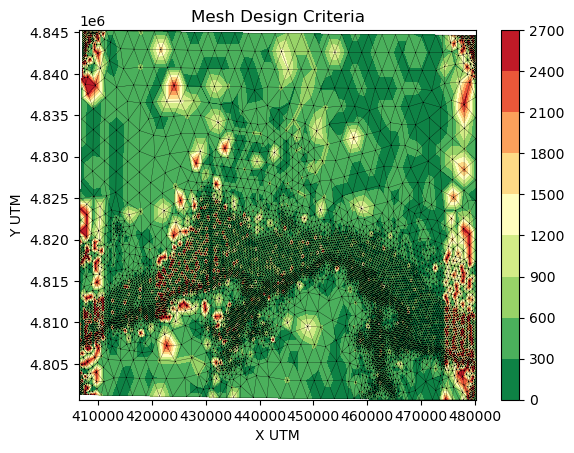

In [6]:
from copy import deepcopy
from bluemath_tk.topo_bathy.mesh_utils import plot_mesh_vals, plot_mesh_edge


geom = ocsmesh.Geom([], base_shape=largest_polygon, base_shape_crs=polygon_domain_crs)

hfun = ocsmesh.Hfun(deepcopy(rasters), hmin=Tmin, hmax=Tfuera)

Depth_cut = [-2000, -250, -100, -75, -25, 2.5]
cf = 100
Crit_size = [26 * cf, 13 * cf, 6.5 * cf, 3.25 * cf, 1.7 * cf]
# exp_rate = 0.01

for i in range(len(Crit_size)):
    hfun.add_topo_bound_constraint(
        value=Crit_size[i],
        upper_bound=Depth_cut[i + 1],
        lower_bound=Depth_cut[i],
        value_type="max",
        rate=exp_rate,
    )
# hfun.add_topo_bound_constraint(
#     value=Tmin,
#     upper_bound=H_dis + Rango_marea * C_deb,
#     lower_bound=H_dis - Rango_marea * C_deb,
#     value_type="max",
#     rate=exp_rate,
# )

hfun_msht = hfun.msh_t()

ocsmesh.utils.finalize_mesh(hfun_msht)

ax = plot_mesh_vals(hfun_msht, cmap="RdYlGn_r")
plot_mesh_edge(hfun_msht, lw=0.2, color="k", ax=ax)

In [7]:
from bluemath_tk.topo_bathy.OCSMod import EuclideanMesh2D


driver = ocsmesh.JigsawDriver(geom=geom, hfun=hfun, initial_mesh=False)
mesh = EuclideanMesh2D(driver.run(remesh_tiny_elements=True).msh_t)

In [8]:
import numpy as np
from bluemath_tk.topo_bathy.mesh_utils import circumcenter


data = EuclideanMesh2D(mesh.msh_t).vert2
coords = np.array([item["coord"] for item in data])
elements = np.array(list(ocsmesh.utils.elements(mesh.msh_t).values()))
triangles_coords = [coords[element] for element in elements]

circumcenter_tri = circumcenter(triangles_coords)

n = circumcenter_tri.shape[0]
nearest_distances = np.zeros(n)

for i in range(n):
    distances = np.linalg.norm(circumcenter_tri[i] - circumcenter_tri, axis=1)
    distances[i] = np.inf
    if any(nearest_distances == np.min(distances)):
        nearest_distances[i] = 1000000000
    else:
        nearest_distances[i] = np.min(distances)
mask1 = nearest_distances < min_dist_circum

In [9]:
import pyproj
from shapely.ops import transform
from bluemath_tk.topo_bathy.mesh_utils import is_any_point_outside


transformer_to_utm = pyproj.Transformer.from_proj(
    pyproj.Proj(proj="latlong", datum="WGS84"),
    pyproj.Proj(proj="utm", zone=UTM_zone, ellps="WGS84"),
)

largest_polygon_utm = transform(
    lambda x, y: transformer_to_utm.transform(x, y), final_polygon_UN
)

exterior_points = list(largest_polygon_utm.exterior.coords)

poly = Polygon(exterior_points)

polyy = poly.buffer(0.02 * poly.area / poly.length)

mask2 = np.array(
    [is_any_point_outside(triangle, polyy) for triangle in triangles_coords]
)

In [10]:
mask = mask1 | mask2
copy_mesh = deepcopy(mesh)
copy_mesh = ocsmesh.utils.clip_elements_by_index(copy_mesh, tria=mask, quad=None)
ocsmesh.utils.finalize_mesh(copy_mesh)

print(f"Elements removed by circumcenter distance condition {mask1.sum()}")
if mask1.sum() > 0:
    B_circo = np.mean(
        [triangle for triangle, m in zip(triangles_coords, mask1) if m], axis=1
    )
else:
    B_circo = np.full((1, 2), np.nan)
print(f"Elements removed due to bad mesh generation {mask2.sum()}")
if mask2.sum() > 0:
    B_mg = np.mean(
        [triangle for triangle, m in zip(triangles_coords, mask2) if m], axis=1
    )
else:
    B_mg = np.full((1, 2), np.nan)

Elements removed by circumcenter distance condition 0
Elements removed due to bad mesh generation 0


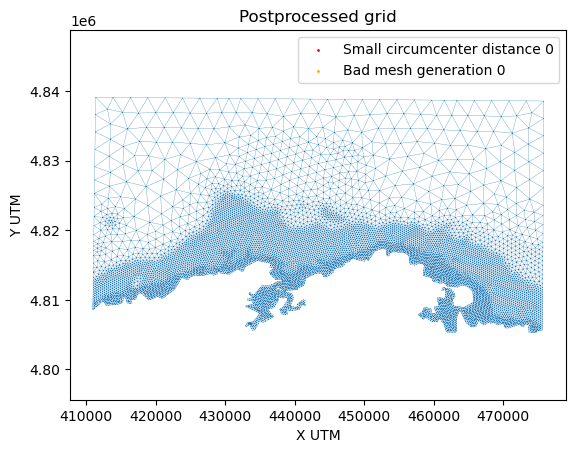

In [11]:
fig, ax = plt.subplots()
ax.triplot(
    mesh.msh_t.vert2["coord"][:, 0],
    mesh.msh_t.vert2["coord"][:, 1],
    triangles=mesh.msh_t.tria3["index"],
    lw=0.2,
)
ax.scatter(
    B_circo[:, 0],
    B_circo[:, 1],
    c="red",
    s=1,
    label=f"Small circumcenter distance {mask1.sum()}",
)
ax.scatter(
    B_mg[:, 0], B_mg[:, 1], c="orange", s=1, label=f"Bad mesh generation {mask2.sum()}"
)
ax.axis("equal")
plt.title("Postprocessed grid")
plt.xlabel("X UTM")
plt.ylabel("Y UTM")
plt.legend()

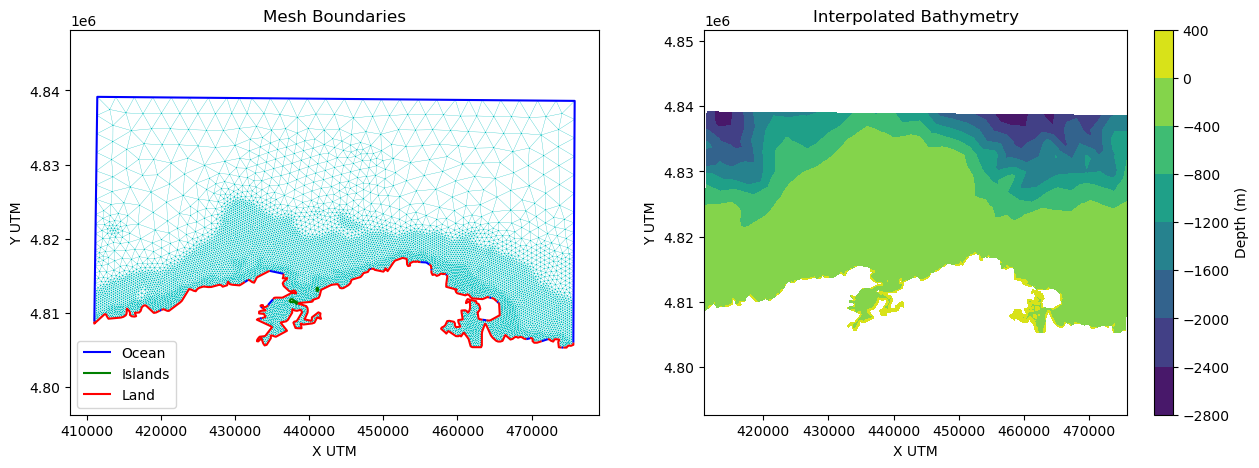

In [12]:
from bluemath_tk.topo_bathy.mesh_utils import plot_boundaries, plot_bati_interp


rasters = [ocsmesh.Raster(p) for p in rasters_path]
copy_mesh.interpolate(rasters, method="linear")
copy_mesh.boundaries.auto_generate(h_bnd)

fig, (axs) = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])
plot_boundaries(copy_mesh, axs[0])
plot_bati_interp(copy_mesh, axs[1])

axs[0].legend()

## Save output files

In [14]:
from bluemath_tk.topo_bathy.mesh_utils import adcirc2netcdf


path_grd = op.join("outputs", f"{city_name}_mesh_adcirc.grd")
path_nc = op.join("outputs", f"{city_name}_mesh_net.nc")

copy_mesh.write(path_grd, format="grd", overwrite=True)
adcirc2netcdf(path_grd, path_nc)